In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.primitives import Estimator

# Teleportación 

In [46]:
def teleport (N, b, J, h,m,stepss):

    def initialize_TFD(qc, beta):
        if beta != 0:
            raise NotImplementedError("Only beta=0 is implemented")
        else:
            for i in range(N):
                qc.h(left_reg[i])
                qc.cx(left_reg[i], right_reg[i])

    #Backwards in time
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    
    #Evolution operator
    def U(h,t):
        U = PauliEvolutionGate(h, time=t, synthesis=LieTrotter(reps=1))
        return U
    
   
    #Coupling between pairs
    terms_site_V  = ['I'*i + 'Z' + 'I'*(N-m-i)+'I'*i + 'Z' + 'I'*(N-m-i) for i in range(N-m)]

    V=1/(N-m)*sum([SparsePauliOp.from_list([(term, 1)]) for term in terms_site_V])
    
    #Expectation values
    estimator = Estimator()

    #Sweep in g 
    g_range = np.linspace(0, 2*np.pi, 50)
    res = np.zeros((2*N+m, len(g_range)))


    for i, g in enumerate(g_range):
        left_reg = QuantumRegister(N, 'Left')
        right_reg = QuantumRegister(N, 'Right')
        message_reg = QuantumRegister(m, 'Message')
    
        qc = QuantumCircuit(message_reg, left_reg, right_reg)
        #qc.x(message_reg)
        initialize_TFD(qc, 0)
        for _ in range(stepss):
            qc.append(U(H_K,-1), left_reg)
            qc.append(U(H_I,-1), left_reg)
            
        for l in range(m):
            qc.swap(message_reg[l], left_reg[l])

        for _ in range(stepss):
            qc.append(U(H_I,1), left_reg)
            qc.append(U(H_K,1), left_reg)
            
        V_gate = PauliEvolutionGate(V, time=g, synthesis=LieTrotter(reps=1))
        qc.append(V_gate, list(range(m, 2*N+1)))
        
        
        for _ in range(stepss):
            qc.append(U(H_K,1), right_reg)
            qc.append(U(H_I,1), right_reg)
            
            
        for j in range(2*N+m):
            op = SparsePauliOp.from_list([("I"*j + "Z" + "I"*(2*N-j), 1)])
    
            expectation_value = estimator.run(qc, op).result().values
    
            res[j, i] = expectation_value
    
    return res
   

    


## Solo canal de salida

In [12]:
def teleport_ch(N, b, J, h,m,stepss):

    def initialize_TFD(qc, beta):
        if beta != 0:
            raise NotImplementedError("Only beta=0 is implemented")
        else:
            for i in range(N):
                qc.h(left_reg[i])
                qc.cx(left_reg[i], right_reg[i])

    #Backwards in time
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    
    #Evolution operator
    def U(h,t):
        U = PauliEvolutionGate(h, time=t, synthesis=LieTrotter(reps=1))
        return U
    
   
    #Coupling between pairs
    terms_site_V  = ['I'*i + 'Z' + 'I'*(N-m-i)+'I'*i + 'Z' + 'I'*(N-m-i) for i in range(N-m)]

    V=1/(N-m)*sum([SparsePauliOp.from_list([(term, 1)]) for term in terms_site_V])
    


    left_reg = QuantumRegister(N, 'Left')
    right_reg = QuantumRegister(N, 'Right')
    message_reg = QuantumRegister(m, 'Message')

    qc = QuantumCircuit(message_reg, left_reg, right_reg)
    #qc.x(message_reg)
    initialize_TFD(qc, 0)
    for _ in range(stepss):
        qc.append(U(H_K,-1), left_reg)
        qc.append(U(H_I,-1), left_reg)
        
    for l in range(m):
        qc.swap(message_reg[l], left_reg[l])

    for _ in range(stepss):
        qc.append(U(H_I,1), left_reg)
        qc.append(U(H_K,1), left_reg)

        
    #Expectation values
    estimator = Estimator()

    #Sweep in g 
    g_range = np.linspace(0, 2*np.pi, 50)
    res = []


    for i, g in enumerate(g_range):
        print('paso g', i)
        qc1=qc
            
        V_gate = PauliEvolutionGate(V, time=g, synthesis=LieTrotter(reps=1))
        qc1.append(V_gate, list(range(m, 2*N+1)))
        
        
        for _ in range(stepss):
            qc1.append(U(H_K,1), right_reg)
            qc1.append(U(H_I,1), right_reg)
            
        
        #Expectation values
    
        op=SparsePauliOp.from_list([("I"*(N-1) + "Z" + "I"*(N+1), 1)])
        
        expectation_value = estimator.run(qc1, op).result().values
        res.append(expectation_value)
    
    return res
   

    


### Cambiar orden entrelazamiento

In [6]:
left_reg = QuantumRegister(N, 'Left')
right_reg = QuantumRegister(N, 'Right')
message_reg = QuantumRegister(m, 'Message')

qc = QuantumCircuit(message_reg, left_reg, right_reg)

for i in range(N):
    qc.h(left_reg[i])
    qc.cx(left_reg[i], right_reg[N-i-1])

qc.draw('mpl')
N=3
m=1
terms_site_V  = ['I'*i + 'Z' + 'I'*(N-m-1-i)+'I'*i + 'Z' + 'I'*(N-m-1-i) for i in range(N-m)]
print(terms_site_V)

['ZIZI', 'IZIZ']


## N=8 m=1

In [8]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
#h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.array([0.19746523, 0.05561701, 0.00075873])      # magnetic field
h=np.random.rand(N)*0.2

tres=[]
for i in range(1,15):
    tres.append(i)
for i in range(5,11):
    tres.append(3*i)
for i in range(11,22,2):
    tres.append(3*i)

swipes=[]
for time in [1,10,15,53]:
    print(time)
    swipes.append(teleport(N,b,J,h,m,time))




1


C:\Users\manue\AppData\Local\Temp\ipykernel_29652\3097988704.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j, i] = expectation_value


10
15
53


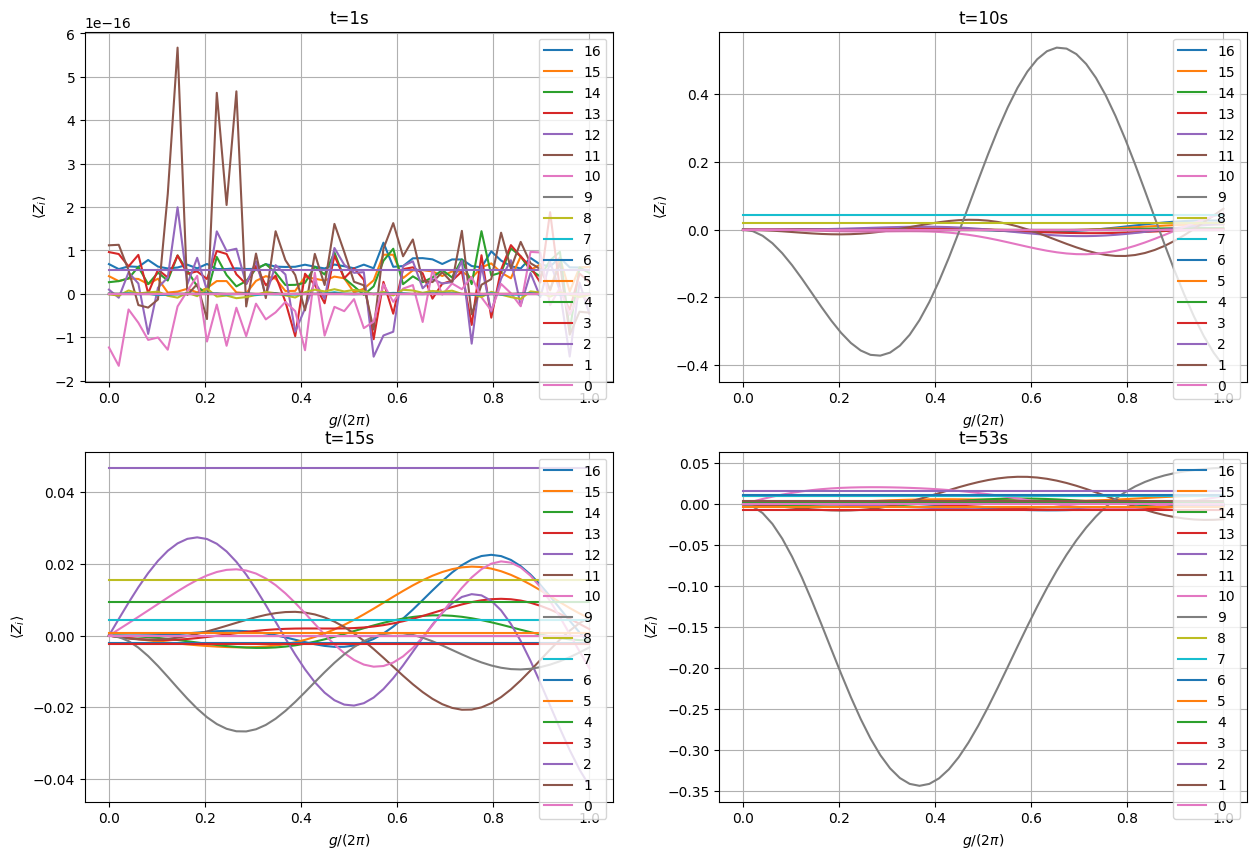

In [10]:
g_range = np.linspace(0, 2*np.pi, 50)
timess=[1,10,15,53]
fig_index=[[0,0],[0,1],[1,0],[1,1]]

figi1=[0,0,1,1]
figi2=[0,1,0,1]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15, 10))


for t in range(len(swipes)):

    for j in range(2*N+m):
        ax[figi1[t],figi2[t]].plot(g_range/(2*np.pi), swipes[t][j], label=str((2*N)-j))
    ax[figi1[t],figi2[t]].set_title('t=%gs' % timess[t])
    ax[figi1[t],figi2[t]].legend()
    ax[figi1[t],figi2[t]].set_xlabel('$g/(2\pi)$')
    ax[figi1[t],figi2[t]].set_ylabel(r'$\langle Z_i\rangle$')
    ax[figi1[t],figi2[t]].grid()
        
    
        


 
plt.savefig(f'swipe_g_4_N={N}.pdf', dpi=600)  # Save the plot as PDF
plt.show()


In [ ]:
def maximo(g,swipe):
    i=np.where(np.max(np.abs(np.array(swipe))))
    return g[i]

In [ ]:
maximos=[]

for i in range(len(swipes)):
    maximo_g=maximo(g_range,swipes[i])
    maximos.append(maximo_g)

    print('Time: ', timess[i], 'best g:', maximo_g)

## N=3 otro t (TFG)

In [28]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
#h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.array([0.19746523, 0.05561701, 0.00075873])      # magnetic field

tres=[]
for i in range(1,15):
    tres.append(i)
for i in range(5,11):
    tres.append(3*i)
for i in range(11,22,2):
    tres.append(3*i)

swipes_3=[]
for time in [1,3,6,53]:
    swipes_3.append(teleport(N,b,J,h,m,time))

C:\Users\manue\AppData\Local\Temp\ipykernel_29652\3097988704.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j, i] = expectation_value


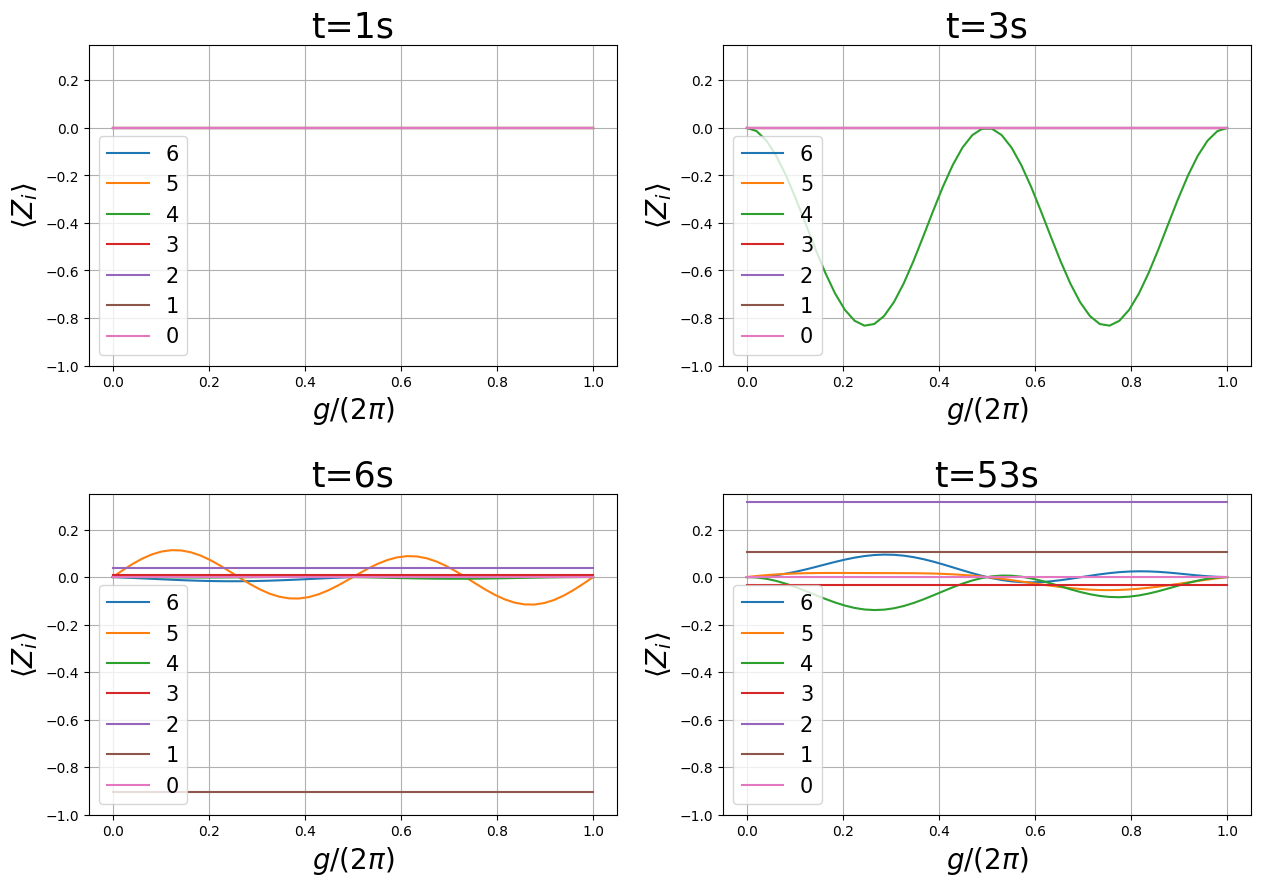

In [45]:
g_range = np.linspace(0, 2*np.pi, 50)
timess=[1,3,6,53]

figi1=[0,0,1,1]
figi2=[0,1,0,1]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15, 10))


for t in range(len(swipes)):
    for j in range(2*N+m):
        ax[figi1[t],figi2[t]].plot(g_range/(2*np.pi), swipes[t][j], label=str((2*N)-j))
    ax[figi1[t],figi2[t]].set_title('t=%gs' % timess[t], fontsize=25)
    ax[figi1[t],figi2[t]].legend(loc='lower left',fontsize=15)
    ax[figi1[t],figi2[t]].set_xlabel('$g/(2\pi)$', fontsize=20)
    ax[figi1[t],figi2[t]].set_ylabel(r'$\langle Z_i\rangle$', fontsize=20)
    ax[figi1[t],figi2[t]].set_ylim(-1,0.35)
    ax[figi1[t],figi2[t]].grid()
        
    
        

plt.subplots_adjust(hspace=0.4)

 
plt.savefig(f'swipe_g_4_N={N}.pdf', dpi=600)  # Save the plot as PDF
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

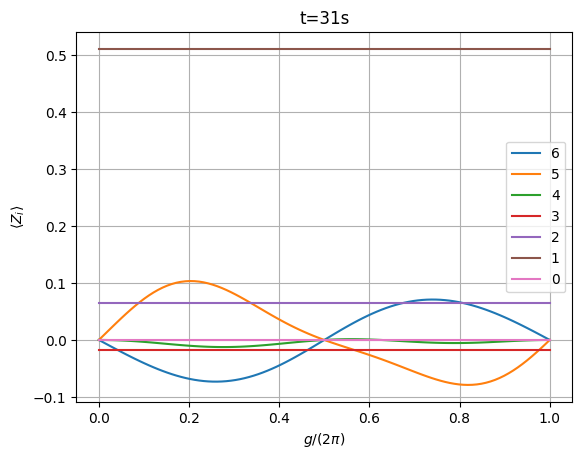

In [13]:
plt.figure(4)
for j in range(2*N+m):
    plt.plot(g_range/(2*np.pi), swipes[0][j], label=str((2*N)-j))
plt.title('t=%gs' % 31)
plt.legend()
plt.xlabel('$g/(2\pi)$')
plt.ylabel(r'$\langle Z_i\rangle$')
plt.grid()
plt.show

## N=8 best g

In [13]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
#h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
# h = np.array([0.19746523, 0.05561701, 0.00075873])      # magnetic field
h=np.random.rand(N)*0.2

times=[20,23,26,31]


swipes_g=[]
for time in times:
    print(time)
    swipes_g.append(teleport_ch(N,b,J,h,m,time))

20
paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49
23
paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49
26
paso g 0
pa

In [17]:
swipes_g.append(teleport_ch(N,b,J,h,m,10))

paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49


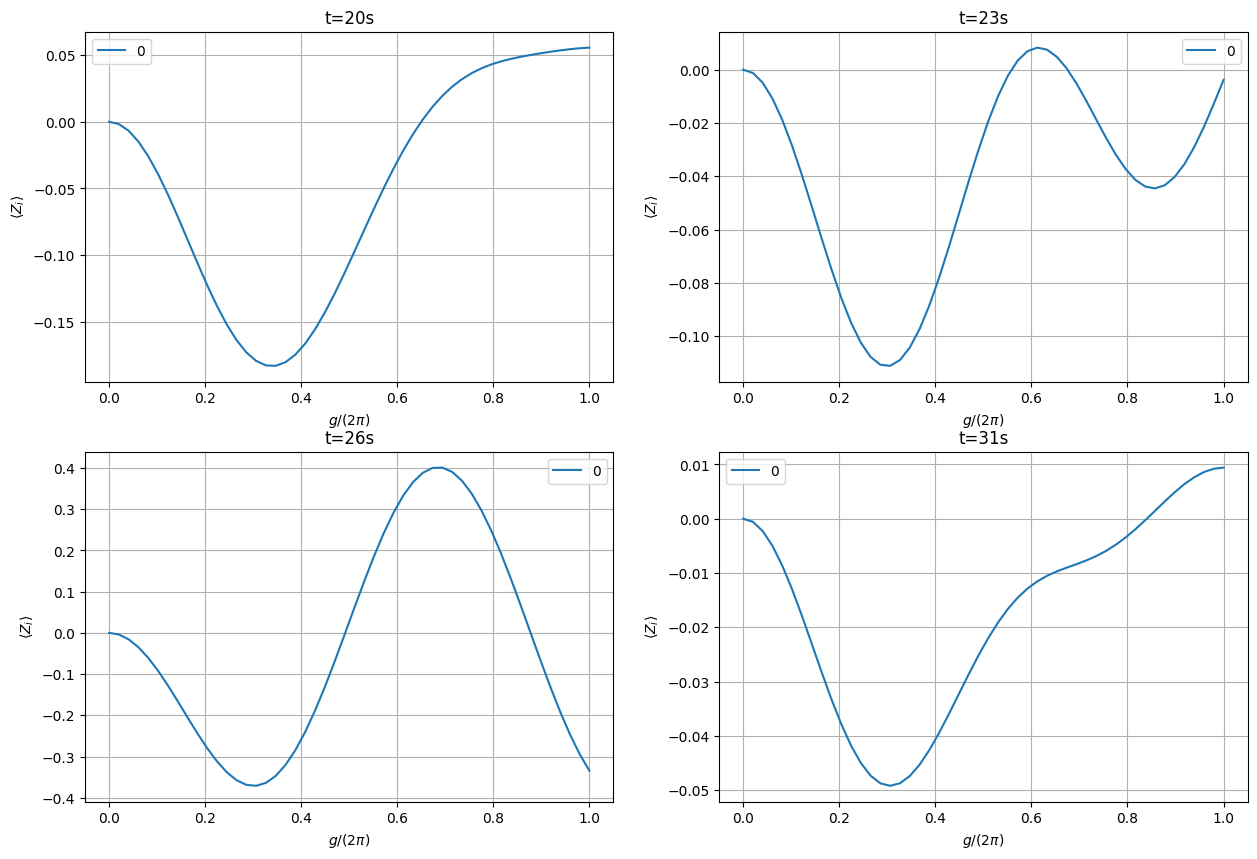

In [16]:
g_range = np.linspace(0, 2*np.pi, 50)
fig_index=[[0,0],[0,1],[1,0],[1,1]]

figi1=[0,0,1,1]
figi2=[0,1,0,1]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15, 10))


for t in range(len(swipes)-1):

    
    ax[figi1[t],figi2[t]].plot(g_range/(2*np.pi), swipes_g[t], label='Canal 9')
    ax[figi1[t],figi2[t]].set_title('t=%gs' % times[t])
    ax[figi1[t],figi2[t]].legend()
    ax[figi1[t],figi2[t]].set_xlabel('$g/(2\pi)$')
    ax[figi1[t],figi2[t]].set_ylabel(r'$\langle Z_i\rangle$')
    ax[figi1[t],figi2[t]].grid()
 
plt.savefig(f'swipe_g_4_N={N} times={times}.pdf', dpi=600)  # Save the plot as PDF
plt.show()    
    
    




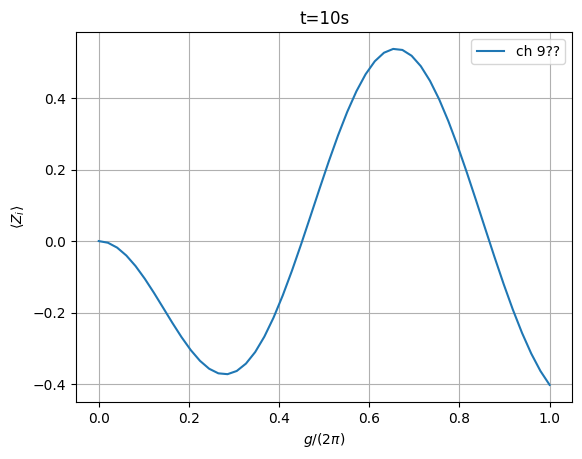

In [18]:
plt.figure(4)
plt.plot(g_range/(2*np.pi), swipes_g[-1], label='ch 9??')
plt.title('t=%gs' % 10)
plt.legend()
plt.xlabel('$g/(2\pi)$')
plt.ylabel(r'$\langle Z_i\rangle$')
plt.grid()
plt.show()

In [19]:
swipe_p=teleport_ch(N,b,J,h,m,58)

paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49


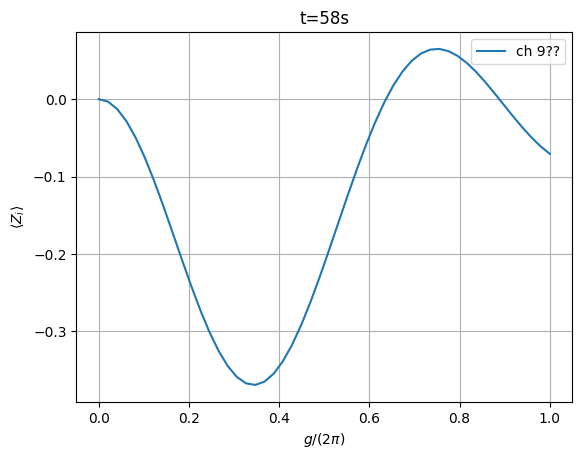

In [21]:
plt.figure(5)
plt.plot(g_range/(2*np.pi), swipe_p, label='ch 9??')
plt.title('t=%gs' % 58)
plt.legend()
plt.xlabel('$g/(2\pi)$')
plt.ylabel(r'$\langle Z_i\rangle$')
plt.grid()
plt.show()

## BKP NO ESTRELLA (TFG)

In [22]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
J = np.pi / 4  # ZZ rotation strength
#h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
# h = np.array([0.19746523, 0.05561701, 0.00075873])      # magnetic field
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])

b = np.linspace((np.pi/4)-0.15, (np.pi/4), 5)
b=np.append(b,np.pi/4)




BKP_swipes_g=[]

for i,bp in enumerate(b):
    print(i)
    BKP_swipes_g.append(teleport_ch(N,bp,J,h,m,8))

0
paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49
1
paso g 0
paso g 1
paso g 2
paso g 3
paso g 4
paso g 5
paso g 6
paso g 7
paso g 8
paso g 9
paso g 10
paso g 11
paso g 12
paso g 13
paso g 14
paso g 15
paso g 16
paso g 17
paso g 18
paso g 19
paso g 20
paso g 21
paso g 22
paso g 23
paso g 24
paso g 25
paso g 26
paso g 27
paso g 28
paso g 29
paso g 30
paso g 31
paso g 32
paso g 33
paso g 34
paso g 35
paso g 36
paso g 37
paso g 38
paso g 39
paso g 40
paso g 41
paso g 42
paso g 43
paso g 44
paso g 45
paso g 46
paso g 47
paso g 48
paso g 49
2
paso g 0
paso 

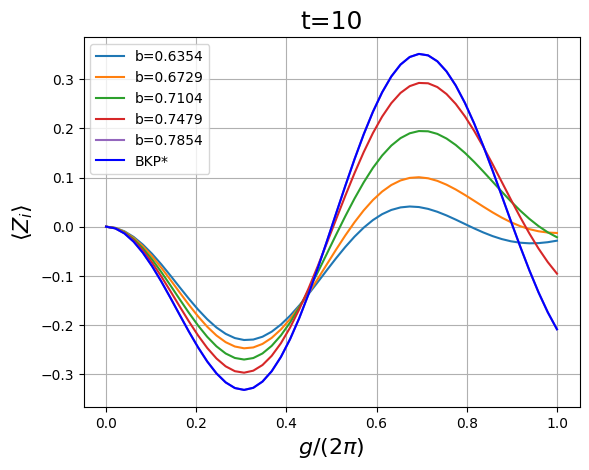

In [44]:
plt.figure(7)

b = np.linspace((np.pi/4)-0.15, (np.pi/4), 5)
b=np.append(b,np.pi/4)

for i in range(len(b)-1):
    plt.plot(g_range/(2*np.pi), BKP_swipes_g[i], label=f'b={np.round(b[i],4)}')
plt.plot(g_range/(2*np.pi), BKP_swipes_g[i],color='blue', label='BKP*')

plt.title('t=%g' % 10, fontsize=18)
plt.legend()
plt.xlabel('$g/(2\pi)$', fontsize=16)
plt.ylabel(r'$\langle Z_i\rangle$', fontsize=16)
plt.grid()
plt.savefig(f'swipes fuera bkp.pdf', dpi=600)  # Save the plot as PDF
plt.show()

## N=4 m=1

C:\Users\manue\AppData\Local\Temp\ipykernel_16136\1079297925.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j, i] = expectation_value


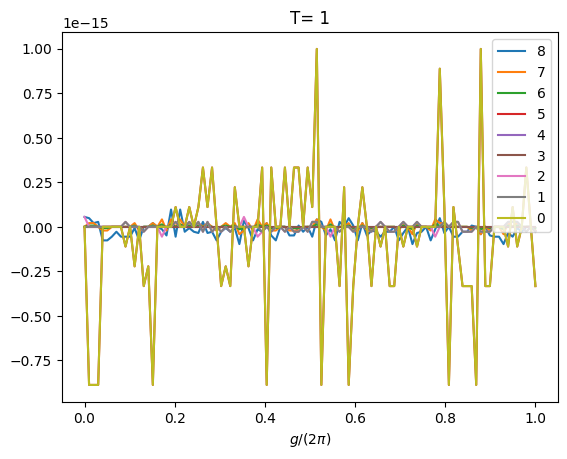

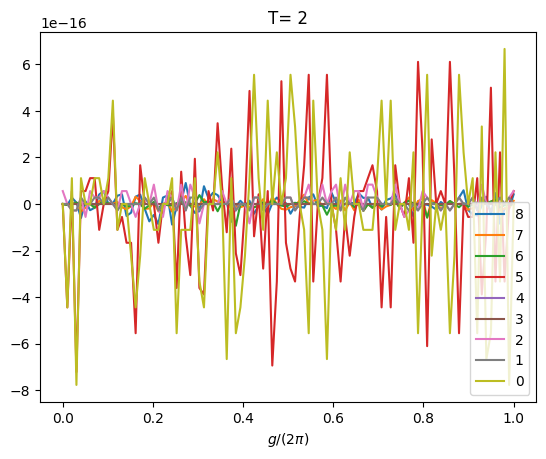

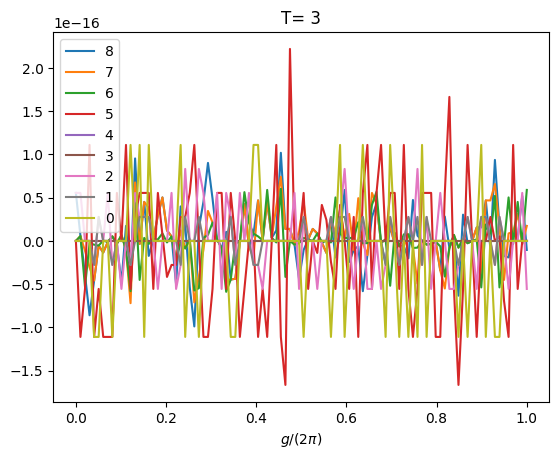

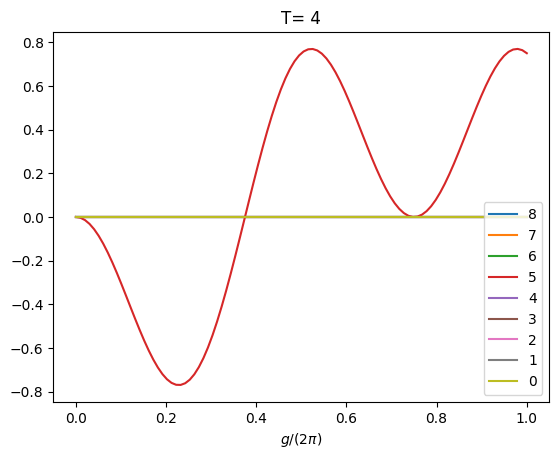

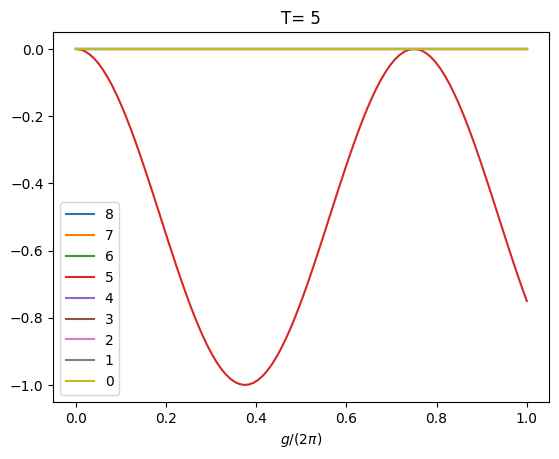

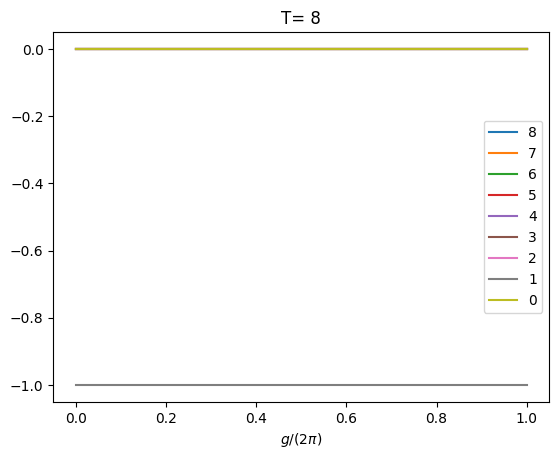

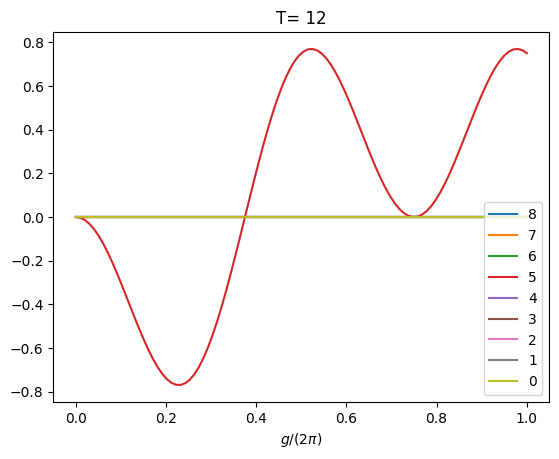

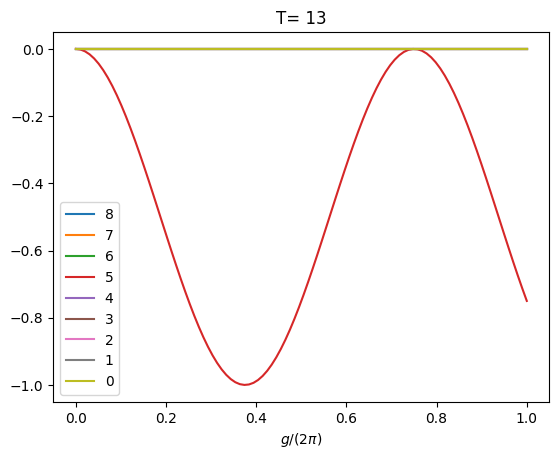

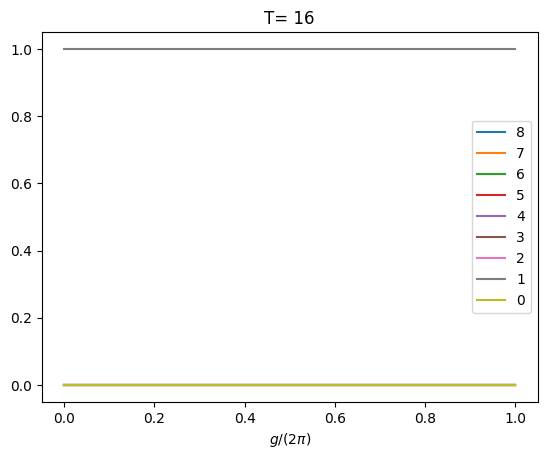

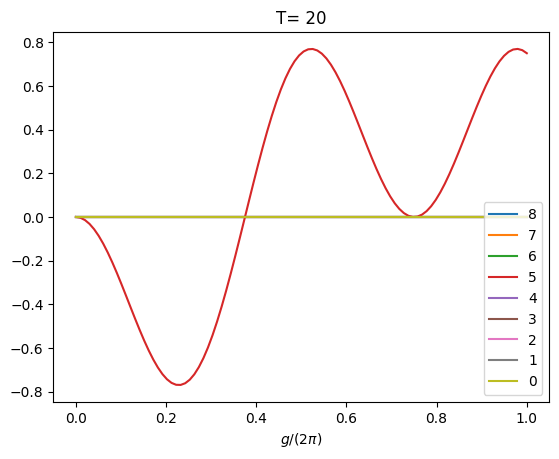

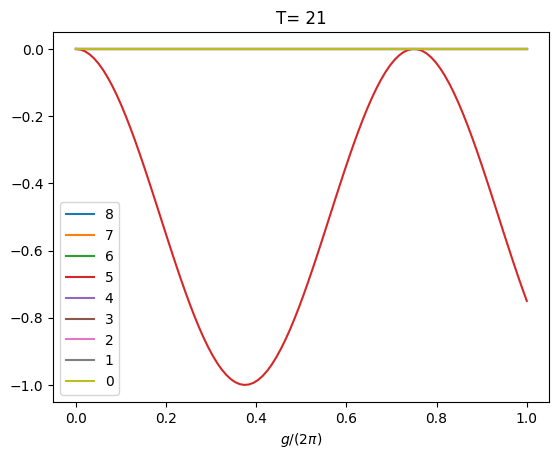

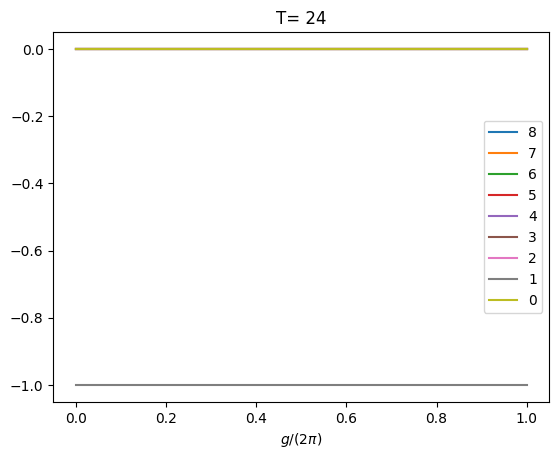

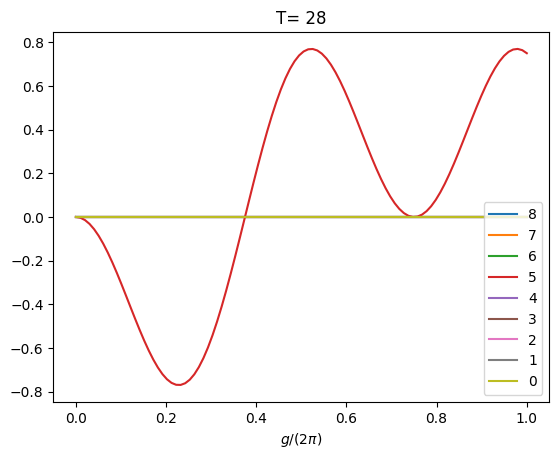

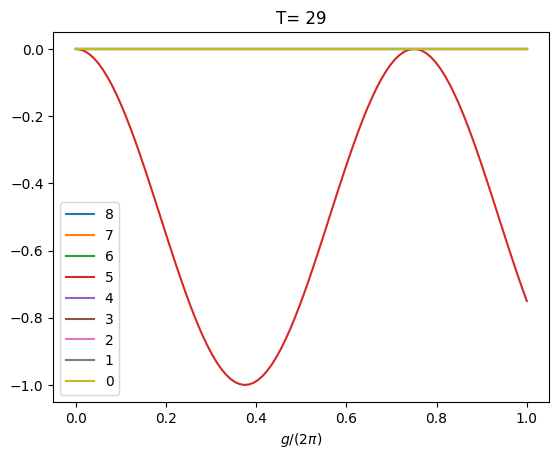

In [3]:
N = 4  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
#h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)        # magnetic field

times=[1,2,3,4,5,8,12,13,16,20,21,24,28,29]

 
for time in times:
    teleport(N,b,J,h,m,time)